In [18]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader  # Use PyTorch Geometric's DataLoader
import torch
import matplotlib.pyplot as plt
from shared.utils import train_classifier, calculate_accuracy
from torch_geometric.nn import summary
torch.manual_seed(123)

dataset = TUDataset(root='/tmp/ENZYMES', name='MUTAG')
print(
    "Num of data points: ",len(dataset),
    ", each with ",dataset.num_node_features," features.\n",sep=""
    )

classes, nums = torch.unique(dataset.y, return_counts=True)

for cls, n in zip(classes, nums):
    print(f'Class {cls.item()}: {n.item()}')

print("naive guessing accuracy: ", max(nums.float()) / sum(nums.float()))

Num of data points: 188, each with 7 features.

Class 0: 63
Class 1: 125
naive guessing accuracy:  tensor(0.6649)


In [36]:
from shared.models import GNNClassifier

model = GNNClassifier(dataset=dataset, hidden_ch=32, dropout=0)
print(summary(model, x=dataset[0].x, edge_index=dataset[0].edge_index, batch=None))

+----------------------------+-------------------+----------------+----------+
| Layer                      | Input Shape       | Output Shape   | #Param   |
|----------------------------+-------------------+----------------+----------|
| GNNClassifier              |                   | [1, 32]        | 3,424    |
| ├─(convolutions)ModuleList | --                | --             | 2,368    |
| │    └─(0)GCNConv          | [20, 7], [2, 46]  | [20, 32]       | 256      |
| │    └─(1)GCNConv          | [20, 32], [2, 46] | [20, 32]       | 1,056    |
| │    └─(2)GCNConv          | [20, 32], [2, 46] | [20, 32]       | 1,056    |
| ├─(lin_layers)ModuleList   | --                | --             | 1,056    |
| │    └─(0)Linear           | [1, 32]           | [1, 32]        | 1,056    |
+----------------------------+-------------------+----------------+----------+


In [37]:
dataset = dataset.shuffle()
N = len(dataset)
train_dataset = dataset[:int(0.6 * N)]
val_dataset = dataset[int(0.6 * N):int(0.8 * N)]
test_dataset = dataset[int(0.8 * N):]

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print("------ SIZE OF DATASETS ------")
print(f"Train: {len(train_dataset)}")
print(f"Valid: {len(val_dataset)}")
print(f"Test:  {len(test_dataset)}")

------ SIZE OF DATASETS ------
Train: 112
Valid: 38
Test:  38


Epoch    T Loss  T Acc  V Loss  V Acc

1/50     3.294   0.383   2.978   0.658
2/50     2.608   0.680   1.870   0.658
3/50     1.395   0.648   0.866   0.658
4/50     0.741   0.688   0.642   0.658
5/50     0.634   0.719   0.649   0.658
6/50     0.641   0.664   0.669   0.658
7/50     0.607   0.688   0.731   0.342
8/50     0.593   0.656   0.791   0.658
9/50     0.745   0.664   0.658   0.711
10/50    0.696   0.500   0.623   0.658
11/50    0.574   0.688   0.635   0.658
12/50    0.594   0.672   0.619   0.658
13/50    0.574   0.750   0.618   0.658
14/50    0.638   0.656   0.632   0.658
15/50    0.595   0.688   0.646   0.711
16/50    0.565   0.758   0.643   0.658
17/50    0.585   0.680   0.611   0.658
18/50    0.559   0.703   0.629   0.737
19/50    0.579   0.742   0.607   0.684
20/50    0.582   0.672   0.601   0.632
21/50    0.534   0.773   0.621   0.737
22/50    0.601   0.727   0.600   0.632
23/50    0.523   0.781   0.617   0.737
24/50    0.533   0.766   0.605   0.658
25/50    0.512   0.773   

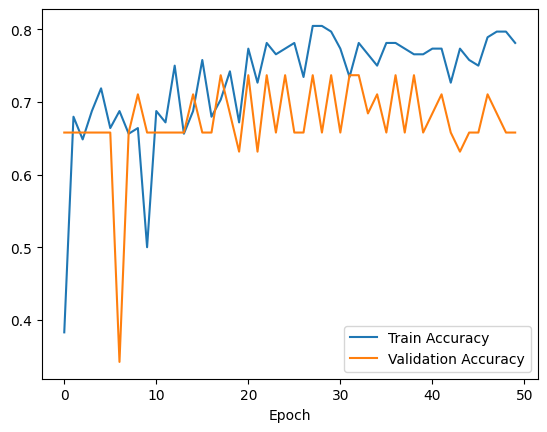

In [38]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Reduced learning rate

train_accs, val_accs = train_classifier(
    N_epochs=50,
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss=loss,
)
    
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

## Test

In [39]:
for batch in test_dataloader:
    model.eval()
    with torch.no_grad():
        out = model(batch.x, batch.edge_index, batch.batch)
        test_acc = calculate_accuracy(out, batch.y)
        print(f'Test Accuracy: {test_acc:.4f}\n')
        out = torch.argmax(out, dim=1)
        y = batch.y
        correct = torch.where(out == y, 1, 0)
        print(torch.sum(correct).item(), "correct predictions out of", len(correct))
        print("pred, true, correct?")
        print(*zip(out.tolist(), y.tolist(), correct.tolist()), sep='\n')

Test Accuracy: 0.7632

29 correct predictions out of 38
pred, true, correct?
(0, 1, 0)
(1, 1, 1)
(1, 0, 0)
(1, 1, 1)
(1, 0, 0)
(1, 0, 0)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 0, 0)
(1, 1, 1)
(0, 0, 1)
(1, 1, 1)
(1, 0, 0)
(0, 0, 1)
(1, 1, 1)
(1, 0, 0)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(0, 0, 1)
(0, 0, 1)
(1, 1, 1)
(1, 1, 1)
(0, 0, 1)
(1, 0, 0)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 0, 0)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
(1, 1, 1)
